In [1]:
from ase import Atoms
from matplotlib import pyplot as plt
import numpy as np
from numpy.testing import assert_allclose
from ase.visualize import view

from pylode.lib.projection_coeffs import DensityProjectionCalculator

### Define helper function to scale a given frame

In [2]:
def build_frames(symbols, positions, cell, scaling_factors):
    """Build an list of `ase.Atoms` instances.

    The list build by scaling the positions and cell size according to
    `scaling_factors`.

    Parameters
    ----------
    symbols : list[str]
        list of symbols
    positions : list of xyz-positions
        Atomic positions
    cell : 3x3 matrix or length 3 or 6 vector
        Unit cell vectors.
    scaling_factors : list[float]
        scaling factor for the positions and the cell
    """
    if len(positions.shape) != 2:
        raise ValueError("Positions must be a (N, 3) array!")
    if positions.shape[1] != 3:
        raise ValueError("Positions must have 3 columns!")
    if cell.shape != (3, 3):
        raise ValueError("Cell must be a 3x3 matrix!")

    frames = []
    for a in scaling_factors:
        frames.append(
            Atoms(symbols=symbols,
                  positions=a * positions,
                  cell=a * cell,
                  pbc=True))

    return frames

### Generate the frames of different crystals

In [42]:
crystal_list = ["NaCl", "CsCl", "ZnS"]
def crystal_dictionary(scaling_factors):
        """Init dictionary for crystal paramaters."""
        d = {k: {} for k in crystal_list}

        d["NaCl"]["symbols"] = 4 * ['Na'] + 4 * ['Cl']
        d["NaCl"]["positions"] = np.array([[.0, .0, .0], [.5, .5, .0],
                                           [.5, .0, .5], [.0, .5, .5],
                                           [.5, .0, .0], [.0, .5, .0],
                                           [.0, .0, .5], [.5, .5, .5]])
        d["NaCl"]["cell"] = np.diag([1, 1, 1])
        
        # primitive unit cell version
        d["NaCl"]["symbols"] = ['Na', 'Cl']
        d["NaCl"]["positions"] = np.array([[0, 0, 0], [1,0,0]])
        d["NaCl"]["cell"] = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
        d["NaCl"]["madelung"] = 1.7476

        frames = build_frames(symbols=d["NaCl"]["symbols"],
                                   positions=d["NaCl"]["positions"],
                                   cell=d["NaCl"]["cell"],
                                   scaling_factors=scaling_factors)
        d["NaCl"]["frames"] = frames

        d["CsCl"]["symbols"] = ["Cs", "Cl"]
        d["CsCl"]["positions"] = np.array([[0, 0, 0], [.5, .5, .5]])
        d["CsCl"]["cell"] = np.diag([1, 1, 1]) 
        d["CsCl"]["madelung"] = 1.7626 * 2 / np.sqrt(3)
        #d["CsCl"]["madelung"] = 1.7626
        
        frames = build_frames(symbols=d["CsCl"]["symbols"],
                                   positions=d["CsCl"]["positions"],
                                   cell=d["CsCl"]["cell"],
                                   scaling_factors=scaling_factors)
        d["CsCl"]["frames"] = frames

        d["ZnS"]["symbols"] = ["Zn", "S"]
        d["ZnS"]["positions"] = np.array([[0, 0, 0], [.5, .5, .5]])
        d["ZnS"]["cell"] = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
        #d["ZnS"]["madelung"] = 1.63805505338879 / 4 / np.sqrt(3)
        d["ZnS"]["madelung"] = 1.63805505338879 * 2 / np.sqrt(3)
        
        frames = build_frames(symbols=d["ZnS"]["symbols"],
                                   positions=d["ZnS"]["positions"],
                                   cell=d["ZnS"]["cell"],
                                   scaling_factors=scaling_factors)
        d["ZnS"]["frames"] = frames
        return d

In [43]:
rcut = 0.15
def test_madelung(crystal_dictionary, crystal_name):
    frames = crystal_dictionary[crystal_name]["frames"]
    n_atoms = len(crystal_dictionary[crystal_name]["symbols"])

    calculator = DensityProjectionCalculator(
        max_radial=1,
        max_angular=0,
        cutoff_radius=rcut,
        smearing=0.15,
        radial_basis="monomial",
        potential_exponent=1,
        subtract_center_contribution=True)

    calculator.transform(frames=frames)
    features = calculator.features
    features = features.reshape(len(frames), n_atoms, *features.shape[1:])

    # Contribution of second atom on first atom
    X = features[:, 0, 0, :] - features[:, 0, 1, :]
    
    return X
    #assert_allclose(-X, crystal_dictionary[crystal_name]["madelung"])

/home/khugueni/miniconda3/lib/python3.8/site-packages/pylode/lib/radial_basis.py:103: RuntimeWarning: invalid value encountered in true_divide
  density = lambda x: np.nan_to_num(erf(x/self.smearing/np.sqrt(2))/x,


Slope =  -0.13632495700713643
offset =  2.8866010009001846
1.7476
Slope =  -0.9826063249930012
offset =  0.7099674830143223
2.035275168947269
Slope =  -0.9884739297685151
offset =  0.6373403450713574
1.8914630520428897


/home/khugueni/miniconda3/lib/python3.8/site-packages/pylode/lib/radial_basis.py:103: RuntimeWarning: invalid value encountered in true_divide
  density = lambda x: np.nan_to_num(erf(x/self.smearing/np.sqrt(2))/x,
/home/khugueni/miniconda3/lib/python3.8/site-packages/pylode/lib/radial_basis.py:103: RuntimeWarning: invalid value encountered in true_divide
  density = lambda x: np.nan_to_num(erf(x/self.smearing/np.sqrt(2))/x,


Text(0, 0.5, 'Energy in some units')

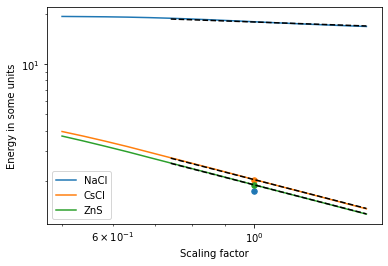

In [44]:
scaling_factors = np.geomspace(0.5,1.5,15)
crystal_dict = crystal_dictionary(scaling_factors)
crystal_list = ["NaCl", "CsCl", "ZnS"]
extra_factors = [1,1,1]

global_factor = 1./np.sqrt(4*np.pi/3.*rcut**3)
#global_factor = 1.

for i, crystal_name in enumerate(crystal_list):
    X = test_madelung(crystal_dict, crystal_name) * global_factor
    
    madelung_lode = -X[:,0,0]
    plt.loglog(scaling_factors, madelung_lode * extra_factors[i], label=crystal_name)
    
    # Linear fit
    coeffs = np.polyfit(np.log(scaling_factors[-15:]), np.log(madelung_lode[-15:]),1)
    fit = np.exp(coeffs[0]*np.log(scaling_factors) + coeffs[1])
    plt.loglog(scaling_factors[-10:], fit[-10:], 'k--')
    
    # Target value
    plt.scatter(1, crystal_dict[crystal_name]['madelung'], s=30)
    
    # Prints
    print('Slope = ', coeffs[0])
    print('offset = ', coeffs[1])
    print(crystal_dict[crystal_name]['madelung'])
plt.legend()
plt.xlabel('Scaling factor')
plt.ylabel('Energy in some units')

In [ ]:
scaling_factors = np.geomspace(0.9,8.5,35)
crystal_dict = crystal_dictionary(scaling_factors)
crystal_list = ["NaCl", "CsCl", "ZnS"]

for crystal_name in crystal_list:
    X = test_madelung(crystal_dict, crystal_name)
    madelung_lode = -X[:,0,0]
    plt.loglog(scaling_factors, madelung_lode, label=crystal_name)
    
    # Linear fit
    coeffs = np.polyfit(np.log(scaling_factors[-15:]), np.log(madelung_lode[-15:]),1)
    fit = np.exp(coeffs[0]*np.log(scaling_factors) + coeffs[1])
    plt.loglog(scaling_factors[-10:], fit[-10:], 'k--')
    
    # Target value
    plt.scatter(1, crystal_dict[crystal_name]['madelung'], s=30)
    
    print('Slope = ', coeffs[0])
    print('offset = ', coeffs[1])
    print(crystal_dict[crystal_name]['madelung'])
plt.legend()
plt.xlabel('Scaling factor')
plt.ylabel('Energy in some units')

In [ ]:
frames = crystal_dict["CsCl"]["frames"]
for frame in frames:
    cell = frame.cell
    print(cell)
    print(frame.get_positions())
    print()

In [ ]:
scaling_factors = np.geomspace(0.9,8.5,25)
crystal_dict = crystal_dictionary(scaling_factors)
framesNaCl = crystal_dict["NaCl"]["frames"]
from ase.io import write
write('nacl.xyz', framesNaCl)